# Project Overview

The goal of this project is to develop an end-to-end data science solution by building a machine learning model that can consistently predict taxi trip duration in New York City with the least error. The data will be sourced from [Kaggle's New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/data). The project will be framed as a regression task and will utilize a supervised learning approach to predict the target variable, which is the trip duration. This project will cover the essential data science techniques starting from data collection up to final evaluation.
 

# Import Dependencies

In [1]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from haversine import haversine, Unit

# Preprocessing
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import root_mean_squared_log_error, make_scorer

# Set seed to ensure reproducibility of results
RANDOM_STATE = 1

# Data Loading

In [2]:
train_data = pd.read_csv("data/train.csv")
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
# Count number of rows and columns
rows, cols = train_data.shape

print(f"Number of rows: {rows:,}")
print(f"Number of columns: {cols}")

Number of rows: 1,458,644
Number of columns: 11


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Cleaning

## Summary of Findings

**Duplicate Records**
- There are no duplicated rows.

**Irrelevant Features**
- `id` is not needed as this is just an identifier and should not have any predictive power.
- `dropoff_datetime` should not be included because this feature is not available at prediction time and contains future information that can cause data leakage (hence why it is also not present in the test set).
- `store_and_fwd_flag` does not really hold any meaningful data relating to the trip duration. Additionally, it has extremely low variance, with 99% of the data containing a value of `N`. So, it's safe to remove this feature to also minimize noise.

**Incorrect Data Types**
- `vendor_id` should be converted to `category` type.
- `pickup_datetime` should be converted to `datetime`.

**Missing Values**
- There are no missing values across all columns.

**Invalid / Out of Range Values**
- `passenger_count` has values of `0` (no passengers) and reaches as high as 9 passengers, which is unrealistic for the capacity of a taxi in NYC. Thus, records with no passengers or counts greater than 5 will be excluded to reflect reality.
- `trip_duration` has both too low (1 second) and too high (900+ hours) duration values. Extremely unrealistic data points will be excluded.

**Outliers**
- Outliers were detected in these columns: `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, and `trip_duration`
- Verdict is to keep them since invalid and out of range data were already excluded in the previous step, which means these data points are probably legitimate. 


## Identifying and Fixing Data Issues

In [6]:
# Store cleaned data into a new dataframe
train_data_clean = train_data.copy()

### Duplicates

In [7]:
# Check for duplicates
num_duplicates = train_data_clean.duplicated().sum()
print(f"Number of duplicate records: {num_duplicates}")

Number of duplicate records: 0


### Irrelevant Features

In [8]:
# Check if `store_and_fwd_flag` has low variance
train_data.value_counts("store_and_fwd_flag", normalize=True)

store_and_fwd_flag
N    0.994485
Y    0.005515
Name: proportion, dtype: float64

Since the vast majority (99%) of records contain the value `N` for `store_and_fwd_flag`, this shows that the feature has extremely low variance. This means that the column can be safely dropped because the low variance would cause the feature to have low predictive power and may just introduce noise to the data.

In [9]:
# Remove irrelevant features
irrelevant_cols = ["id", "dropoff_datetime", "store_and_fwd_flag"]
train_data_clean = train_data_clean.drop(columns=irrelevant_cols)

### Incorrect Data Types

In [10]:
train_data_clean["vendor_id"] = train_data_clean["vendor_id"].astype("category")
train_data_clean["pickup_datetime"] = pd.to_datetime(train_data_clean["pickup_datetime"], errors="coerce")

### Missing Values

In [11]:
# Check for missing data
print("Missing values per column:")
print(train_data.isna().sum())

Missing values per column:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


There are no missing values in any of the columns, so it is safe to proceed to the next step.

### Invalid / Out of Range Values

In [12]:
# Check for invalid/inconsistent categories
train_data_clean["vendor_id"].unique().tolist()


[2, 1]

The categories in `vendor_id` are as expected (two taxi vendors), so no inconsistent values exist here.

In [13]:
# Check for suspicious passenger counts
train_data_clean["passenger_count"].apply(["min", "max"])

min    0
max    9
Name: passenger_count, dtype: int64

According to [NYC.gov](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page), The max limit of an NYC taxi should be 5 passengers. So, passenger counts greater than this should be removed to reflect reality.

Additionally, records with a passenger count of 0 will also be removed as a taxi trip should have at least one passenger.

In [14]:
# Count how many rows are affected
unrealistic_passengers = len(train_data_clean[(train_data_clean["passenger_count"] == 0) | (train_data_clean["passenger_count"] > 5)])

print(f"Number of rows affected: {unrealistic_passengers:,}")
print(f"Proportion of data: {unrealistic_passengers / len(train_data_clean) * 100:.2f}%")

Number of rows affected: 48,398
Proportion of data: 3.32%


Since the affected data is just 3.32%, it would be safe to exclude these records.

In [15]:
# Exclude rows with passenger counts outside the 1-5 range
train_data_clean = train_data_clean[train_data_clean["passenger_count"].between(1, 5)]

To make it easier to interpret the trip durations, conversions to minutes and hours will also be provided along with the original seconds values:

In [16]:
# Check for suspicious trip durations
trip_times_converted = pd.DataFrame({
    "duration_secs": train_data_clean["trip_duration"],
    "duration_mins": train_data_clean["trip_duration"] / 60,
    "duration_hrs": train_data_clean["trip_duration"] / 3600 
})

trip_times_converted.describe().loc[['min', '25%', '50%', '75%', 'max']]

,duration_secs,duration_mins,duration_hrs
min,1.0,0.016667,0.000278
25%,397.0,6.616667,0.110278
50%,662.0,11.033333,0.183889
75%,1075.0,17.916667,0.298611
max,3526282.0,58771.366667,979.522778


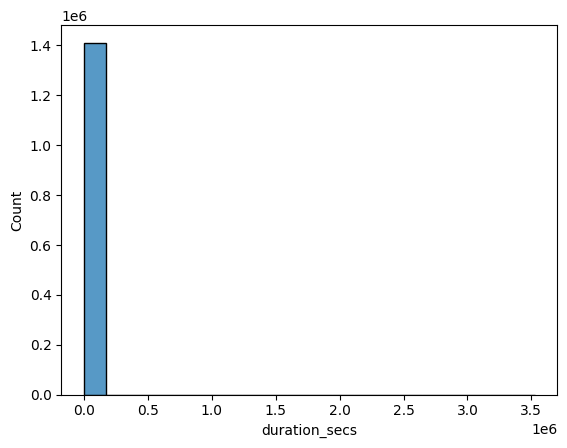

In [17]:
sns.histplot(data=trip_times_converted, x="duration_secs", bins=20)
plt.show()

The trip durations have very short (1 second) and extremely long (~978 hours) duration values, which are far too unrealistic. As reflected in the histogram above, this causes severely skewed data with a significantly wide range, which can negatively impact model performance.

Thus, records with unrealistic durations will be excluded. Based on forums I have read, a reasonable range of duration values is 60-7200 seconds (1min to 2hrs). So, only records that fit in this range will be included in the cleaned dataset.

In [18]:
# Count how many rows are affected
unrealistic_durations = len(train_data_clean[(train_data_clean["trip_duration"] < 1) | (train_data_clean["trip_duration"] > 7200)])

print(f"Number of rows affected: {unrealistic_durations:,}")
print(f"Proportion of data: {unrealistic_durations / len(train_data_clean) * 100:.2f}%")

Number of rows affected: 2,116
Proportion of data: 0.15%


Since it only affects 0.15% of the data, it is safe to proceed with excluding these records.

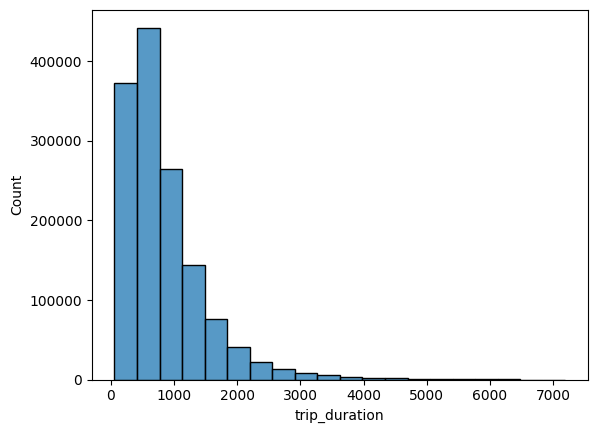

In [19]:
# Subset data to only include trips with duration of 1min to 2hrs
train_data_clean = train_data_clean[train_data_clean["trip_duration"].between(60, 7200)]

# Visualize distribution of transformed trip_duration
sns.histplot(data=train_data_clean, x="trip_duration", bins=20)
plt.show()

Looking at the filtered data above, although the data is still moderately skewed, the durations are now within a more realistic range of values.

To identify out of range taxi trips, [Wikipedia](https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City) provided the following border coordinates for NYC:

- top = 40.92
- bottom = 40.49
- left = -74.27
- right = -73.68

In [20]:
# NYC boundary coordinates
lat_top = 40.92
lat_bot = 40.49
long_left = -74.27
long_right = -73.68

# Define condition for coordinates within NYC area
in_nyc_bounds = (
    train_data_clean['pickup_latitude'].between(lat_bot, lat_top) &
    train_data_clean['dropoff_latitude'].between(lat_bot, lat_top) &
    train_data_clean['pickup_longitude'].between(long_left, long_right) &
    train_data_clean['dropoff_longitude'].between(long_left, long_right)
)

# Check for out of range pickup and dropoff coordinates
out_of_nyc_trips = len(train_data_clean[~in_nyc_bounds])
print(f"Number of rows affected: {out_of_nyc_trips:,}")
print(f"Proportion of data: {out_of_nyc_trips / len(train_data_clean) * 100:.2f}%")

Number of rows affected: 1,020
Proportion of data: 0.07%


There are around 1,000 trips that exceed the boundaries of NYC. However, since they only consitute 0.07% of the data, it is safe to drop these rows.

In [21]:
train_data_clean = train_data_clean[in_nyc_bounds]

### Outliers

For detecting outliers, the Interquartile Range (IQR) method will be used. Outliers are identified if they are:
- Greater than 1.5 x IQR
- Less than 1.5 x IQR

In [22]:
# Define function for reusability since this will be applied to multiple columns
def find_outliers(df, col):
    # Calculate first and third quartiles (25th and 75th percentiles)
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    # Calculate IQR
    iqr = q3 - q1

    # Calculate lower and upper bounds
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)

    # Identify outliers, which are the values outside the bounds
    return df[(df[col] < lower) | (df[col] > upper)]


# Count how many outliers across columns
numeric_cols = train_data_clean.select_dtypes(["float", "int"])

for col in numeric_cols:
    outliers = find_outliers(train_data_clean, col)
    count_outliers = len(outliers)
    print(f"Column: {col}")
    print(f"Count of outliers: {count_outliers:,}\n")

Column: passenger_count
Count of outliers: 105,728

Column: pickup_longitude
Count of outliers: 78,817

Column: pickup_latitude
Count of outliers: 49,031

Column: dropoff_longitude
Count of outliers: 73,102

Column: dropoff_latitude
Count of outliers: 67,781

Column: trip_duration
Count of outliers: 69,559



There are thousands of outliers detected in the above columns using the IQR method. However, since invalid and out of range data were already removed in the earlier steps, these outliers could be a result of extreme but genuine data points. Therefore, the outliers will be kept. This can be revisited in the future to compare a model trained with outliers vs a model trained without outliers.

## Inspect Cleaned Data

In [23]:
train_data_clean.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,455
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,435


In [24]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1398726 entries, 0 to 1458643
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   vendor_id          1398726 non-null  category      
 1   pickup_datetime    1398726 non-null  datetime64[ns]
 2   passenger_count    1398726 non-null  int64         
 3   pickup_longitude   1398726 non-null  float64       
 4   pickup_latitude    1398726 non-null  float64       
 5   dropoff_longitude  1398726 non-null  float64       
 6   dropoff_latitude   1398726 non-null  float64       
 7   trip_duration      1398726 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(2)
memory usage: 86.7 MB


# Feature Engineering

**Strategy**
- Break down `pickup_datetime` into more granular and insightful features to better capture temporal patterns
  - Month
  - Day of week
  - Hour of day
  - Weekend (Saturday, Sunday)
  - Rush hour (According to [Blacklane](https://www.blacklane.com/en/blog/travel/rush-hour-in-nyc/), rush hour is between 6-10am and 4-8pm)
- Create **trip distance** feature from pickup and dropoff coordinates. The recommended approach is to use [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) because this is a simple yet better approach than using the standard distance formula, as the Haversine formula also takes into account the curvature of the Earth.

In [25]:
# Create specific temporal features
train_data_clean["month"] = train_data_clean["pickup_datetime"].dt.month # Jan - 1; Dec - 12
train_data_clean["day_of_week"] = train_data_clean["pickup_datetime"].dt.day_of_week # Monday - 0; Sunday - 6
train_data_clean["hour"] = train_data_clean["pickup_datetime"].dt.hour

train_data_clean["is_weekend"] = train_data_clean["pickup_datetime"].dt.day_of_week.isin([5, 6])

rush_hours = [6, 7, 8, 9, 16, 17, 18, 19] # 6-10am; 4-8pm
train_data_clean["is_rush_hour"] = train_data_clean["pickup_datetime"].dt.hour.isin(rush_hours)

# Drop `pickup_datetime` since its temporal features were already extracted
train_data_clean = train_data_clean.drop(columns="pickup_datetime")

# Create trip distance feature using Haversine formula
def compute_haversine_dist(row):
    return haversine(
        (row["pickup_latitude"], row["pickup_longitude"]), 
        (row["dropoff_latitude"], row["dropoff_longitude"]), 
        unit=Unit.KILOMETERS
    )

train_data_clean["trip_distance_km"] = train_data_clean.apply(compute_haversine_dist, axis=1)

# Inspect transformed data
train_data_clean.head()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day_of_week,hour,is_weekend,is_rush_hour,trip_distance_km
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,0,17,False,True,1.498523
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,6,0,True,False,1.805510
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,1,11,False,False,6.385107
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,2,19,False,True,1.485500
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,5,13,True,False,1.188590


In [26]:
train_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1398726 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   vendor_id          1398726 non-null  category
 1   passenger_count    1398726 non-null  int64   
 2   pickup_longitude   1398726 non-null  float64 
 3   pickup_latitude    1398726 non-null  float64 
 4   dropoff_longitude  1398726 non-null  float64 
 5   dropoff_latitude   1398726 non-null  float64 
 6   trip_duration      1398726 non-null  int64   
 7   month              1398726 non-null  int32   
 8   day_of_week        1398726 non-null  int32   
 9   hour               1398726 non-null  int32   
 10  is_weekend         1398726 non-null  bool    
 11  is_rush_hour       1398726 non-null  bool    
 12  trip_distance_km   1398726 non-null  float64 
dtypes: bool(2), category(1), float64(5), int32(3), int64(2)
memory usage: 105.4 MB


# Exploratory Data Analysis

## Univariate Analysis

In [27]:
# Summary statistics for numeric variables
numeric_cols = train_data_clean.select_dtypes(include=["float", "int"]).columns
train_data_clean[numeric_cols].describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,month,day_of_week,hour,trip_distance_km
count,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06,1.398726e+06
mean,1.516661e+00,-7.397365e+01,4.075099e+01,-7.397362e+01,4.075179e+01,8.397851e+02,3.517216e+00,3.048883e+00,1.361908e+01,3.438155e+00
std,1.058737e+00,3.768428e-02,2.782800e-02,3.468486e-02,3.186540e-02,6.511829e+02,1.680958e+00,1.953907e+00,6.400488e+00,3.873236e+00
min,1.000000e+00,-7.425921e+01,4.049620e+01,-7.426747e+01,4.049620e+01,6.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,-7.399188e+01,4.073740e+01,-7.399133e+01,4.073592e+01,4.010000e+02,2.000000e+00,1.000000e+00,9.000000e+00,1.244569e+00
50%,1.000000e+00,-7.398178e+01,4.075411e+01,-7.397979e+01,4.075453e+01,6.650000e+02,4.000000e+00,3.000000e+00,1.400000e+01,2.106137e+00
75%,2.000000e+00,-7.396748e+01,4.076834e+01,-7.396316e+01,4.076978e+01,1.075000e+03,5.000000e+00,5.000000e+00,1.900000e+01,3.887497e+00
max,5.000000e+00,-7.369088e+01,4.091156e+01,-7.368046e+01,4.092000e+01,7.191000e+03,6.000000e+00,6.000000e+00,2.300000e+01,4.510971e+01


In [28]:
# Frequency table for categorical variables
train_data_clean.value_counts("vendor_id")

vendor_id
2    726212
1    672514
Name: count, dtype: int64

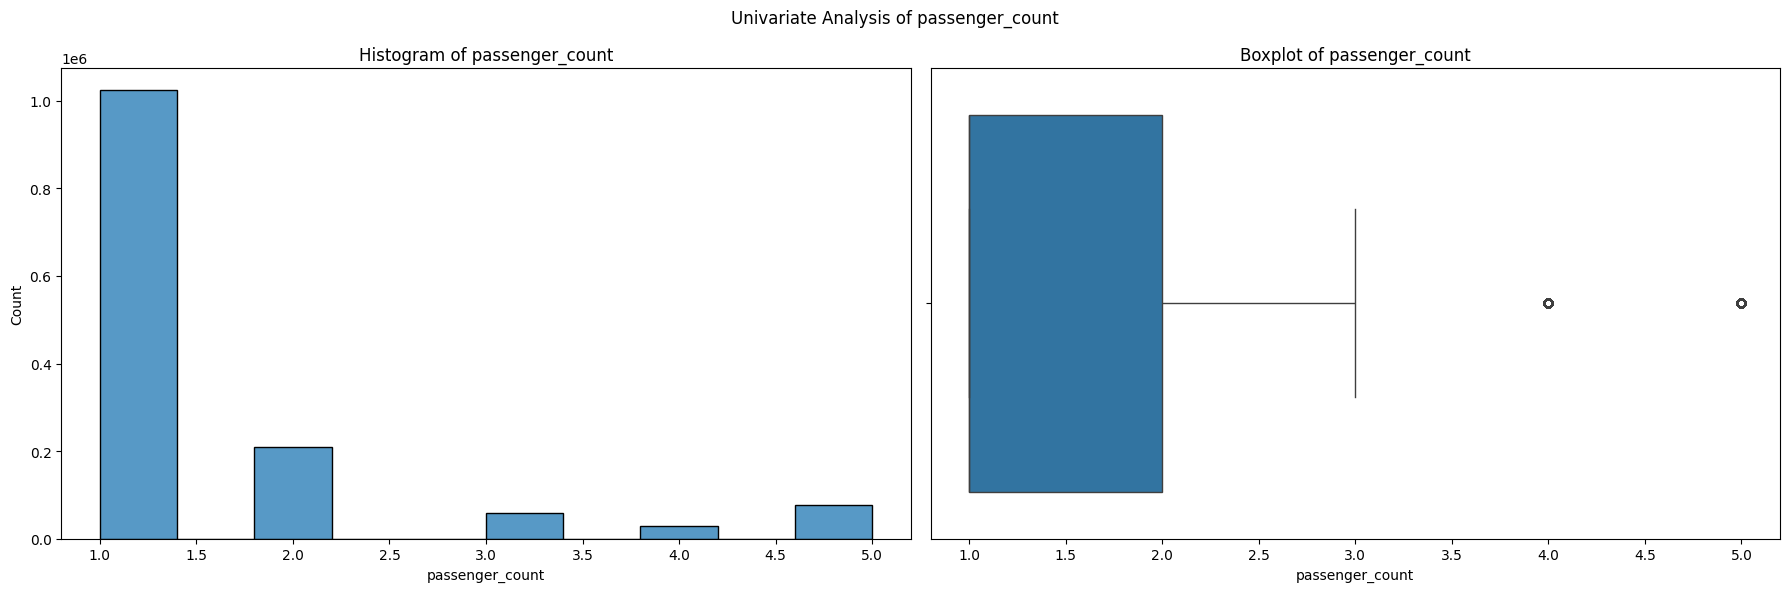

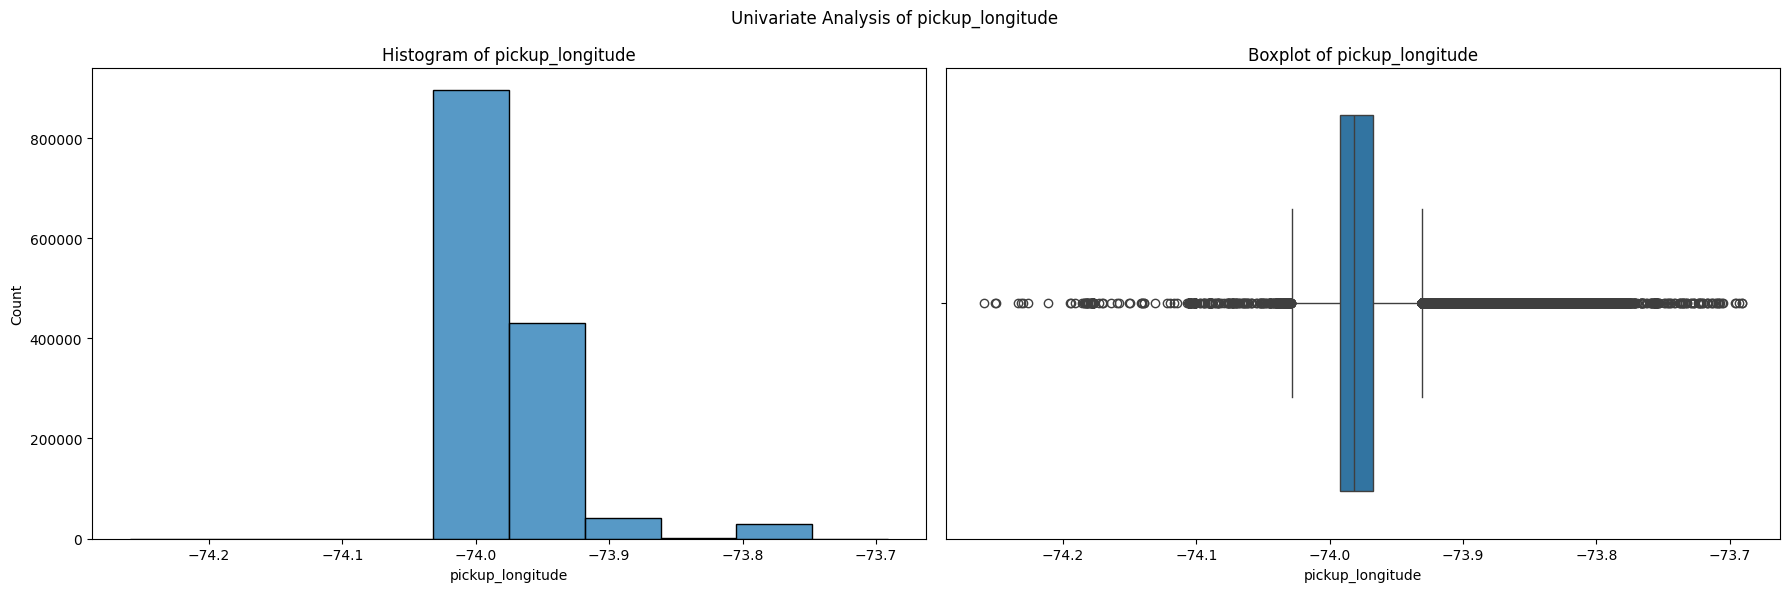

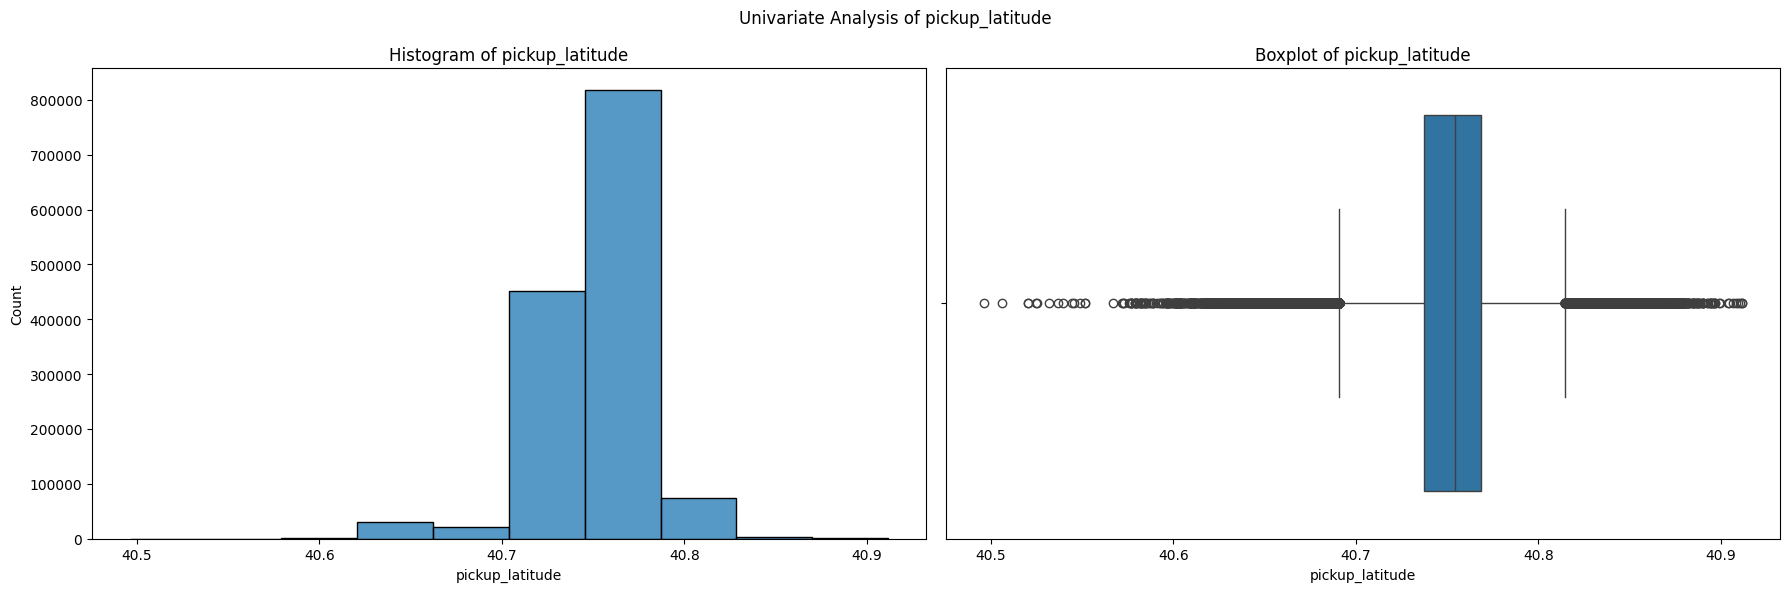

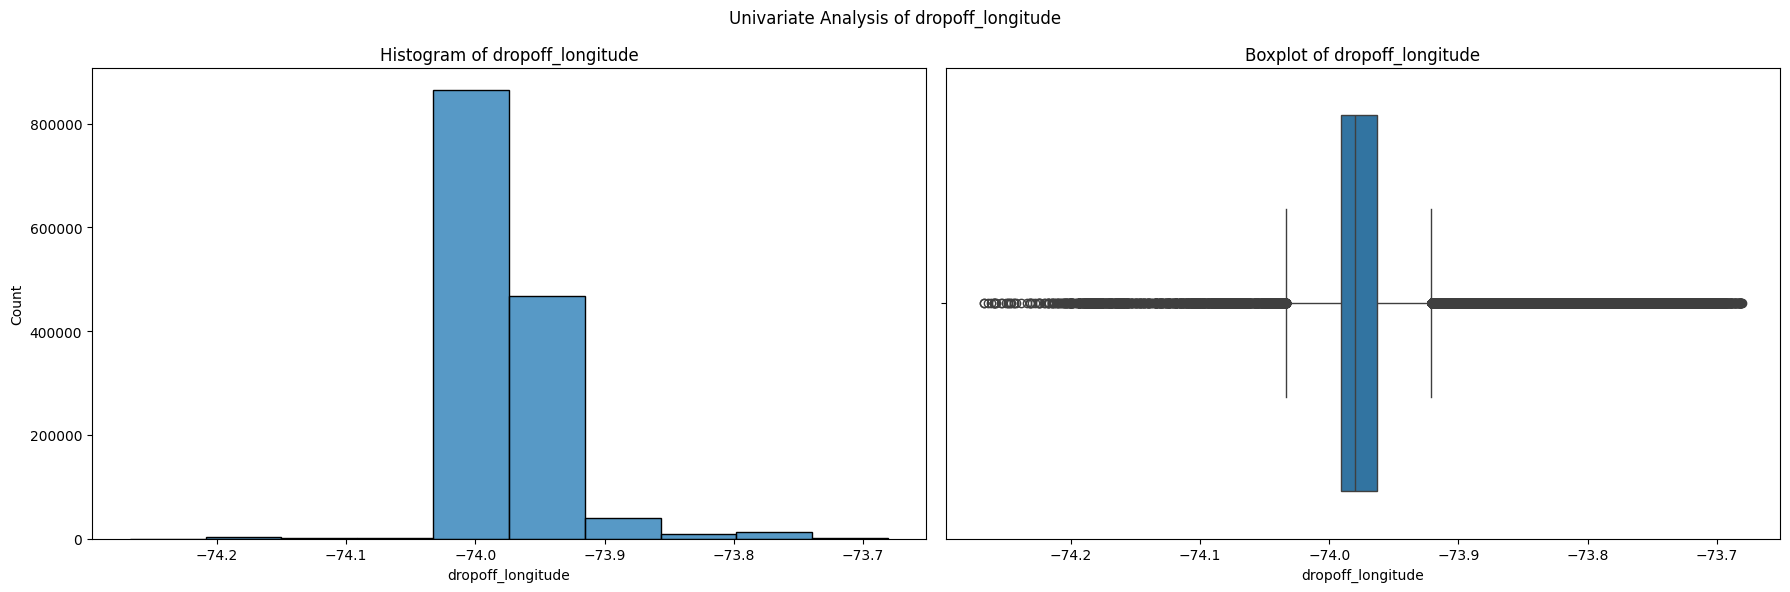

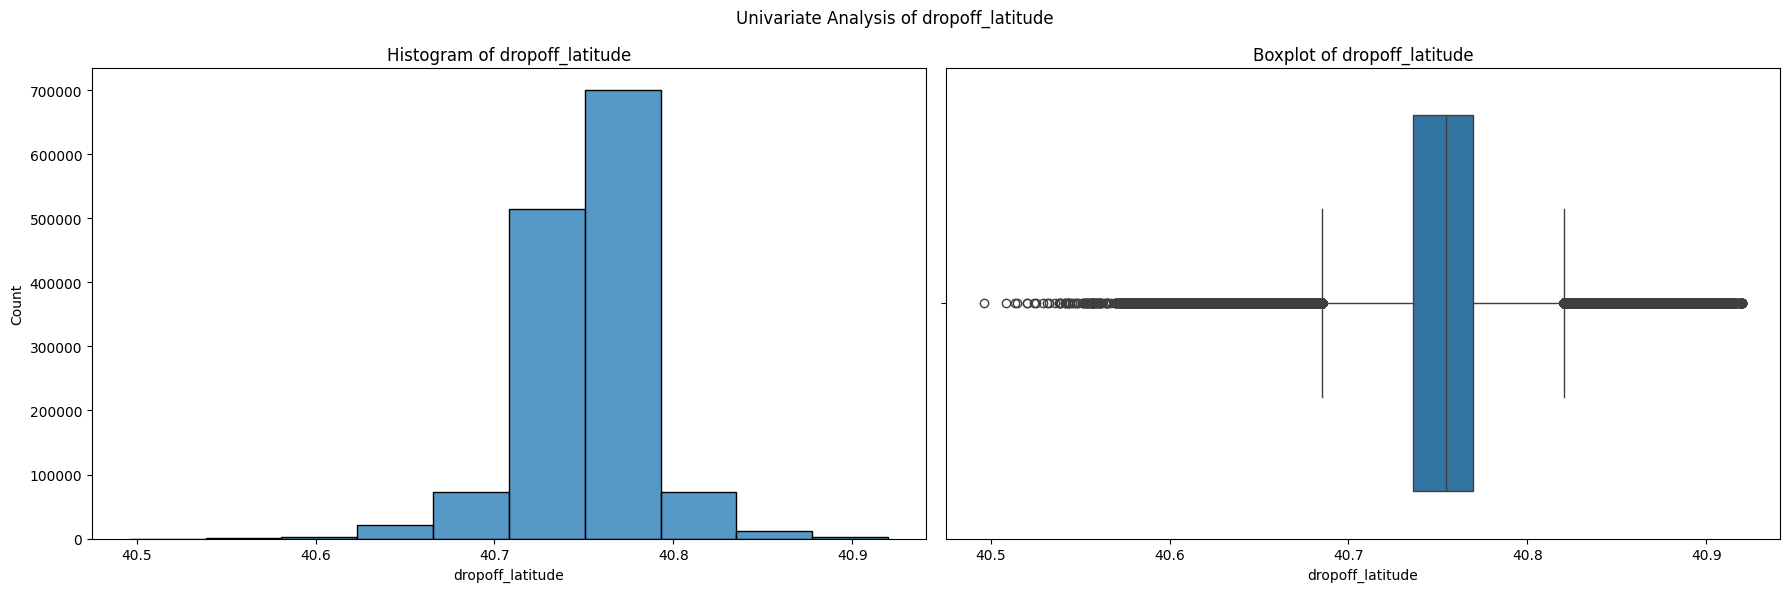

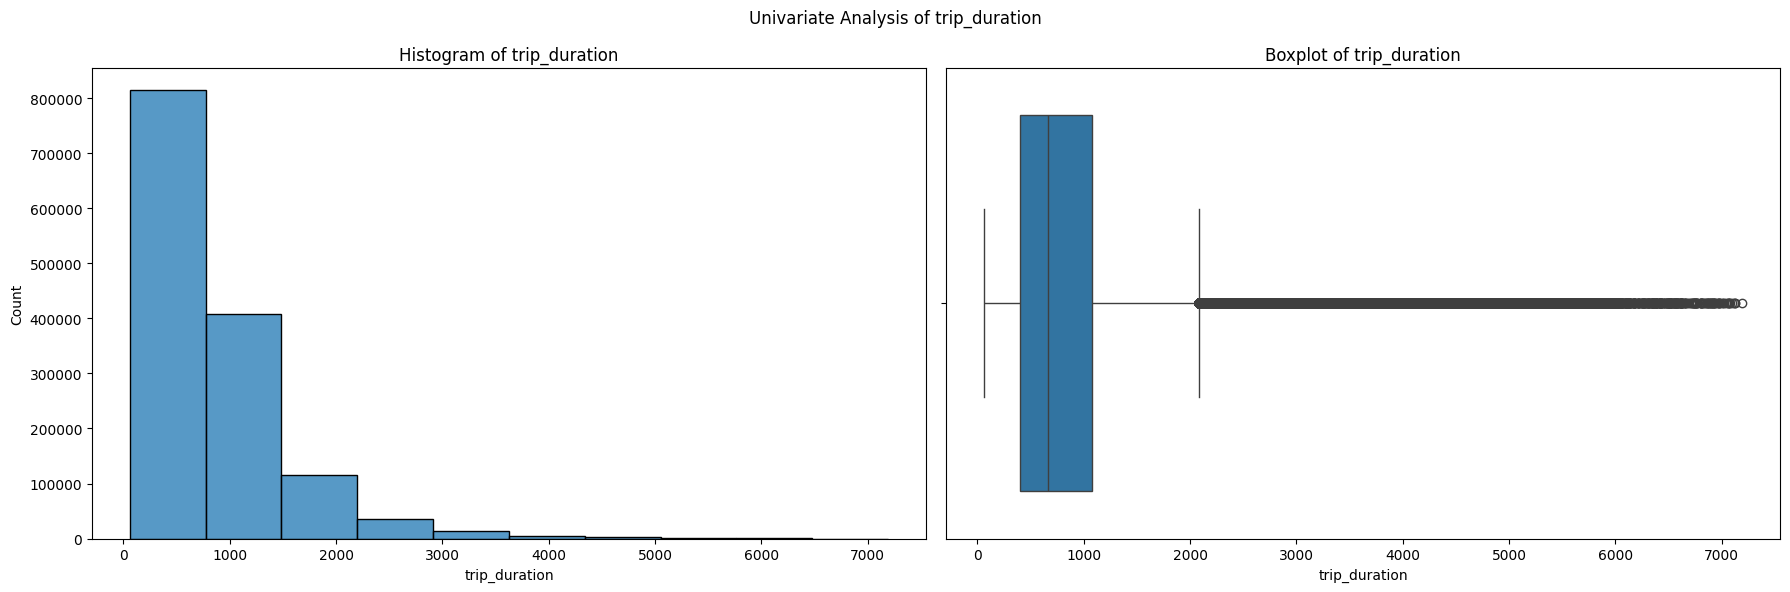

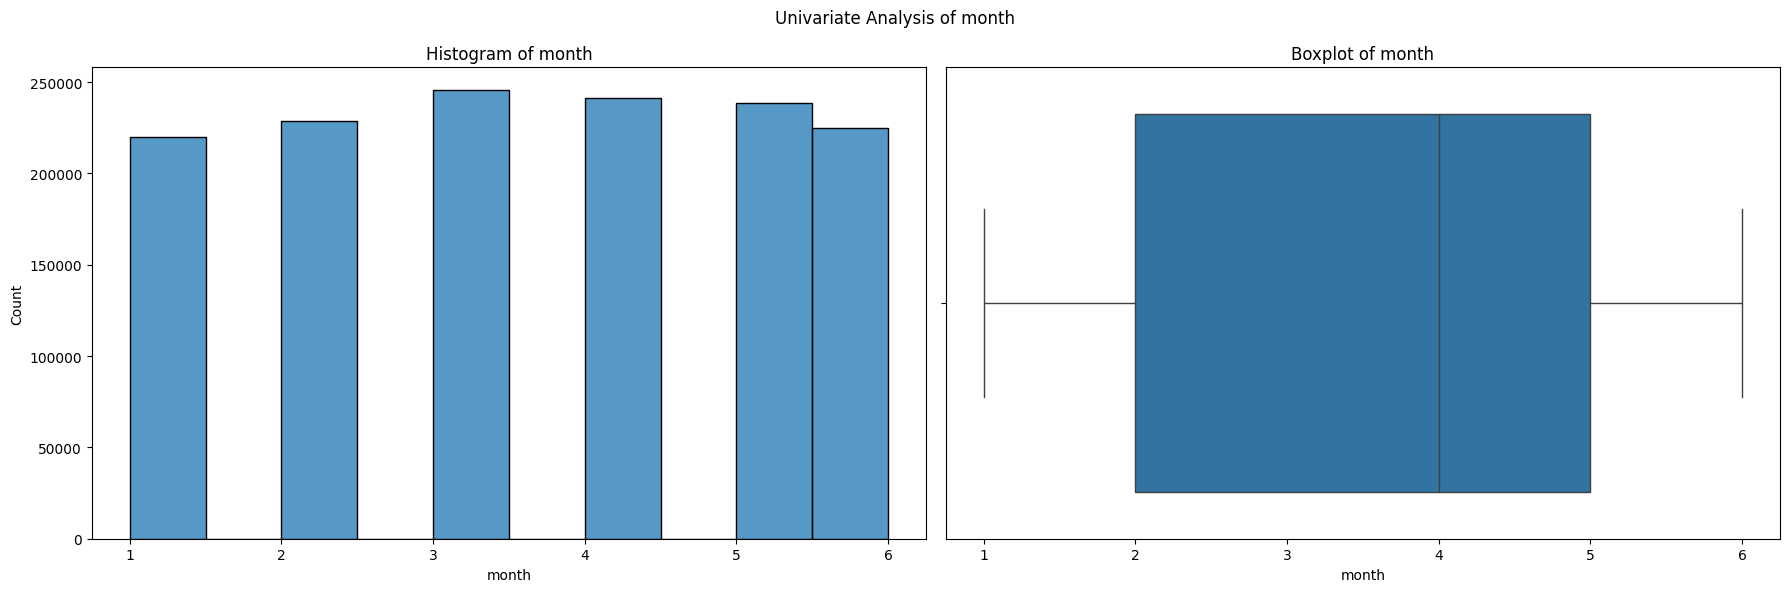

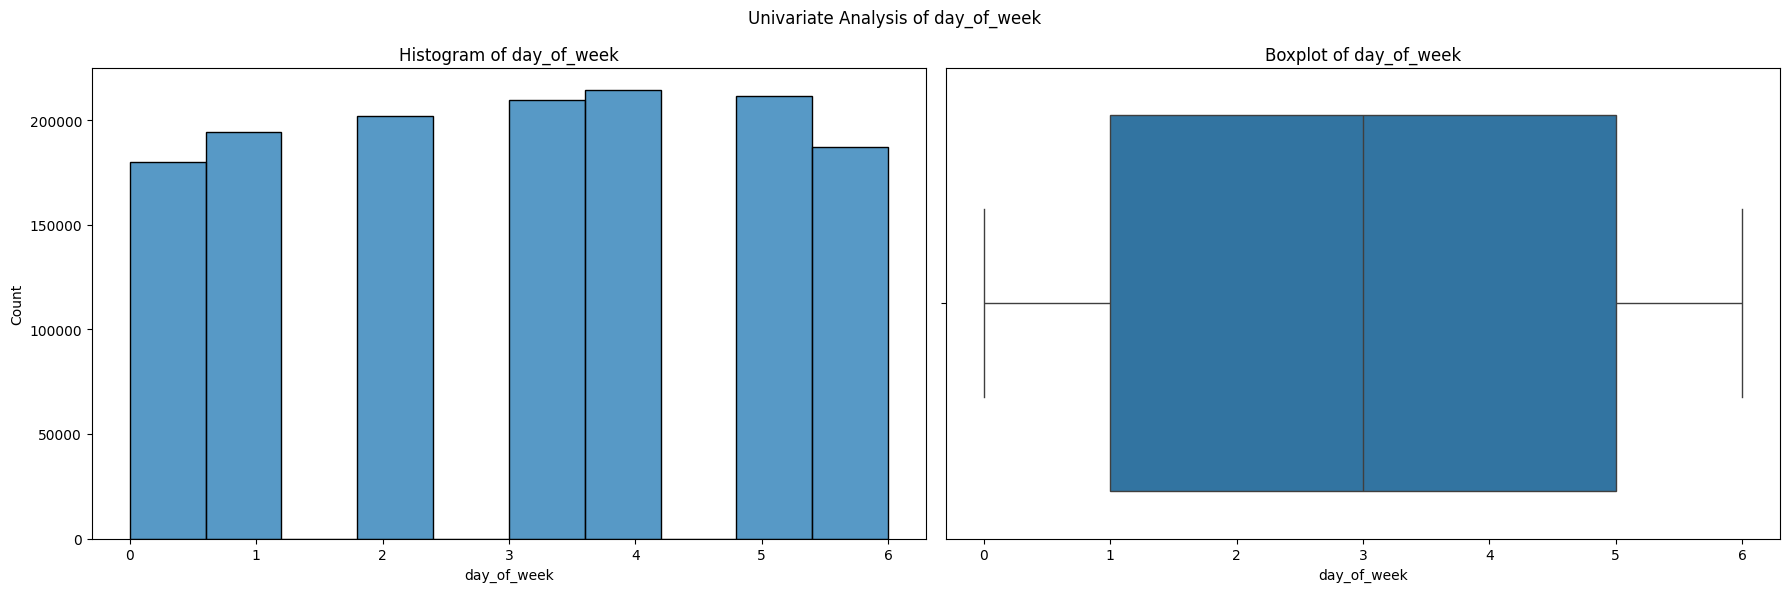

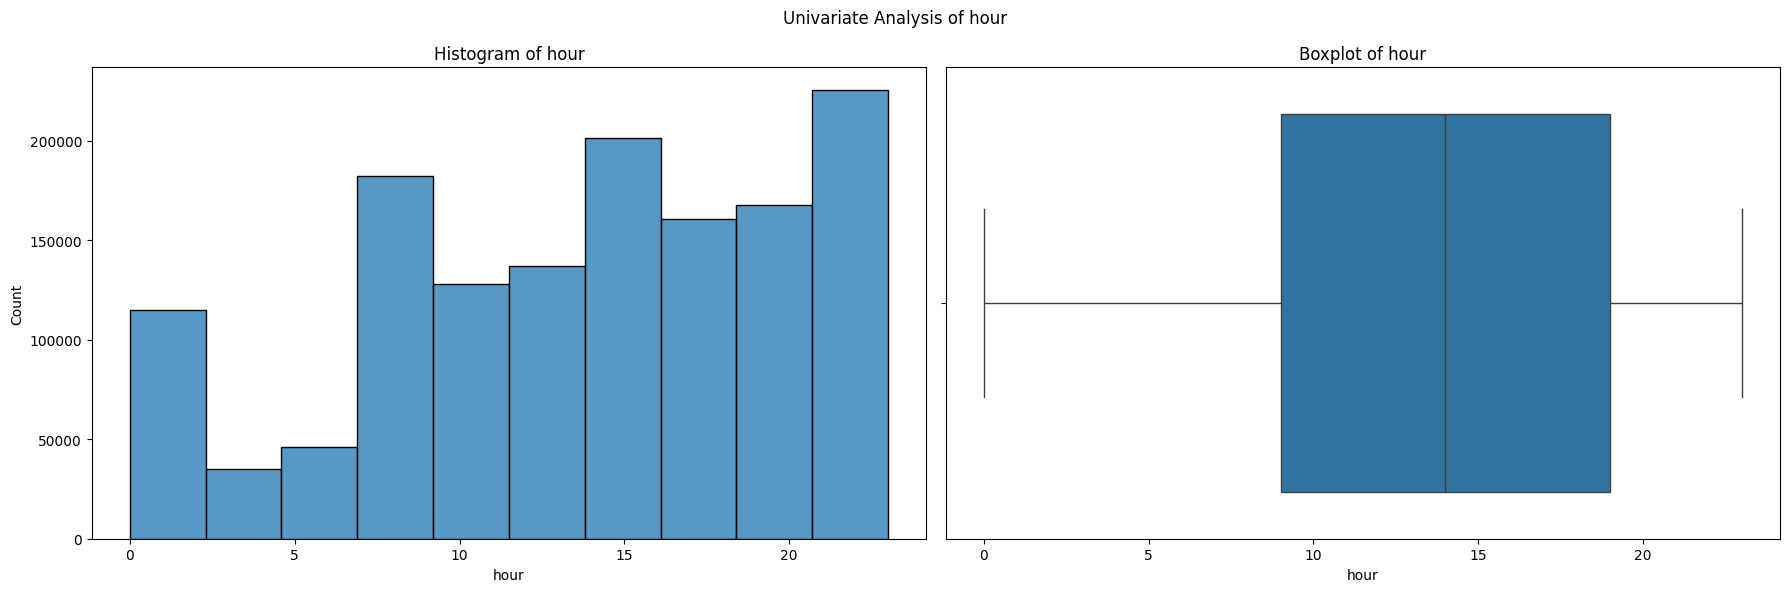

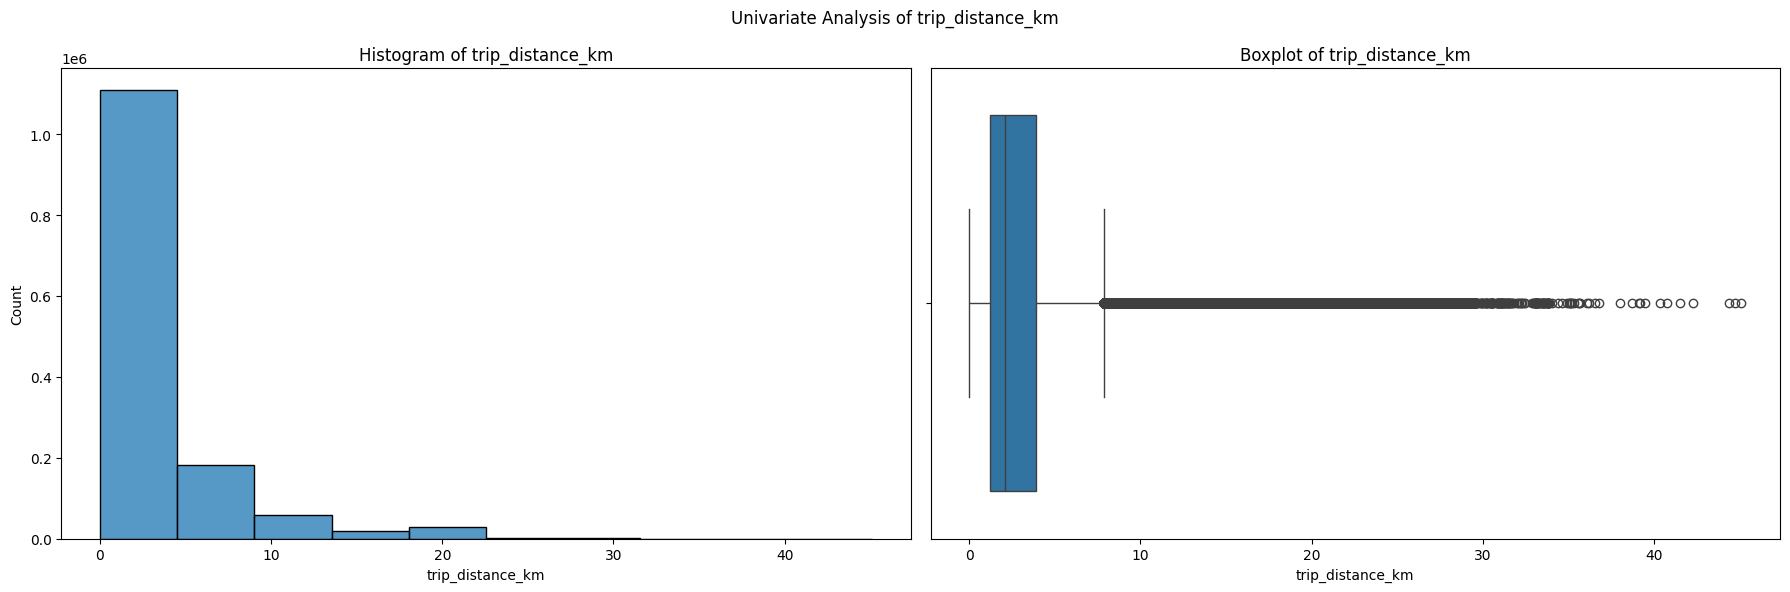

In [29]:
# Display histograms and boxplots for numeric variables
for col in numeric_cols:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    fig.suptitle(f"Univariate Analysis of {col}")

    # Left: Histogram
    sns.histplot(data=train_data_clean, x=col, bins=10, ax=ax[0])
    ax[0].set_title(f"Histogram of {col}")

    # Right: Box Plot
    sns.boxplot(data=train_data_clean, x=col, ax=ax[1])
    ax[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

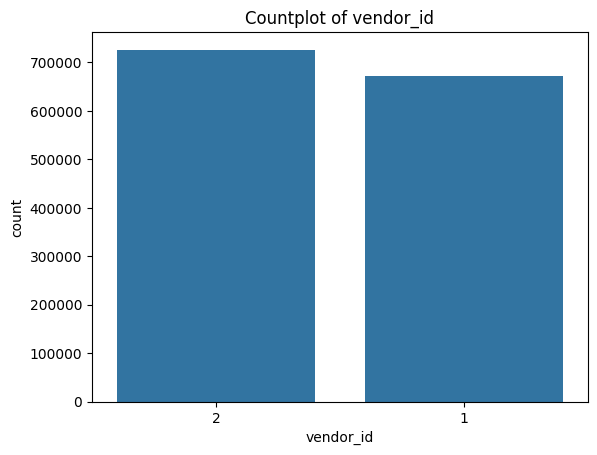

In [30]:
# Display count plot for categorical variables
order = train_data_clean["vendor_id"].value_counts().index

sns.countplot(data=train_data_clean, x="vendor_id", order=order)

plt.title(f"Countplot of vendor_id")
plt.show()
    

**Insights**

- There are significantly more solo passenger trips in the dataset compared to multi-passenger trips, as shown in the `passenger_count` histogram.
- For pickup and dropoff coordinates, their data exhibits a narrow and sharp peak at the center with a small standard deviation, which indicates that most trips occured near the city center with outliers mapping some trips at the outskirts of the city. 
- For `trip_duration`, the data demonstrates right-skewness wherein the vast majority of trips lasted less than 2,000 seconds (~33mins). Since this is the prediction target, it is recommended to apply a log transformation during preprocessing to mitigate the impact of its severe skewness.
- For temporal features, `month` and `day_of_week` show almost a uniform distribution, while there is a trend where number of trips increase as the `hour` of day progresses, with spikes coinciding with rush hour times.
- Majority of trips had a distance of less than 10km, but there are some high distance trips that span more than 40km (which could indicate a trip from one end of the city to the other end).
- Between the two vendors, trips are almost equally divided between them but vendor 2 has slightly more trips.

## Bivariate Analysis

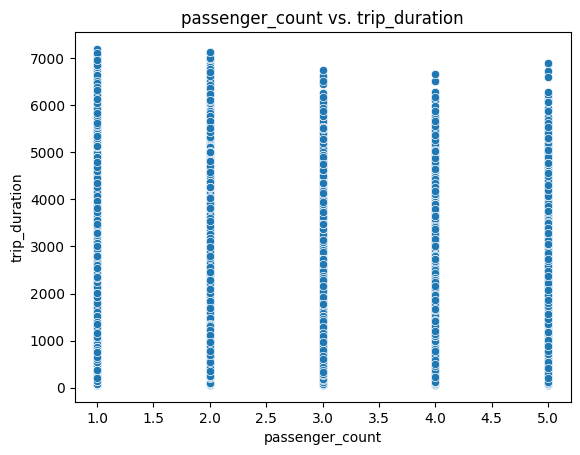

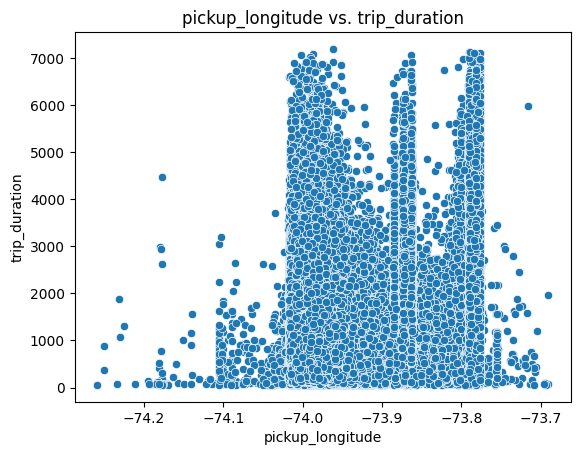

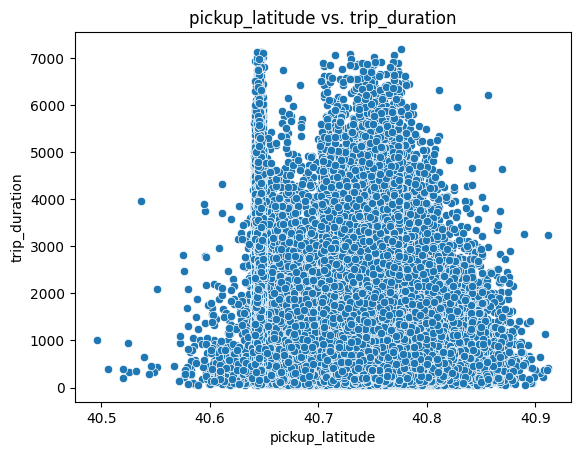

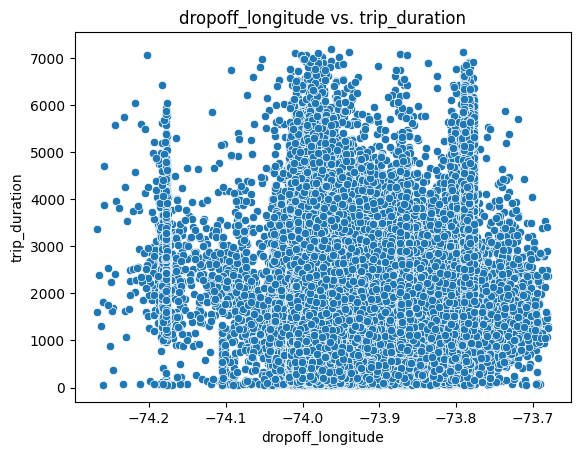

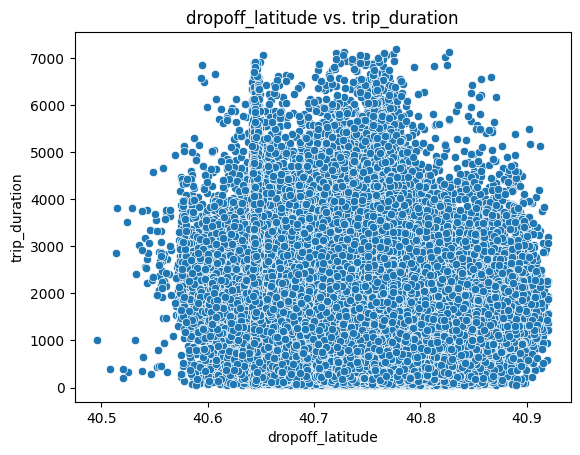

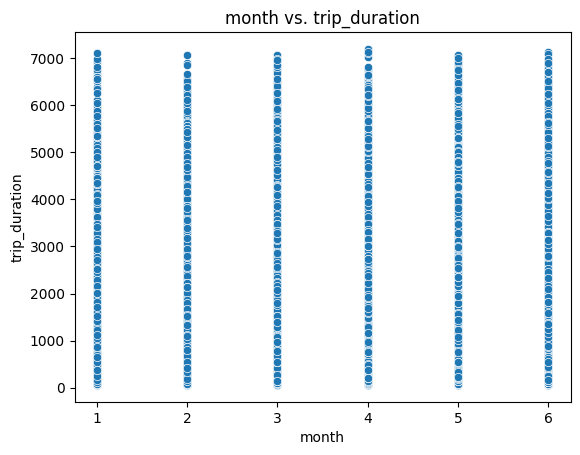

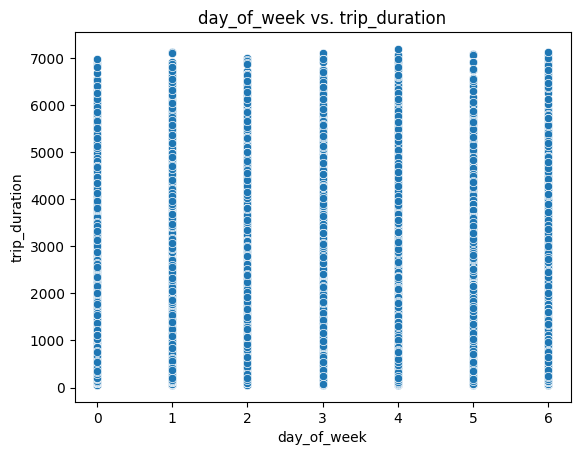

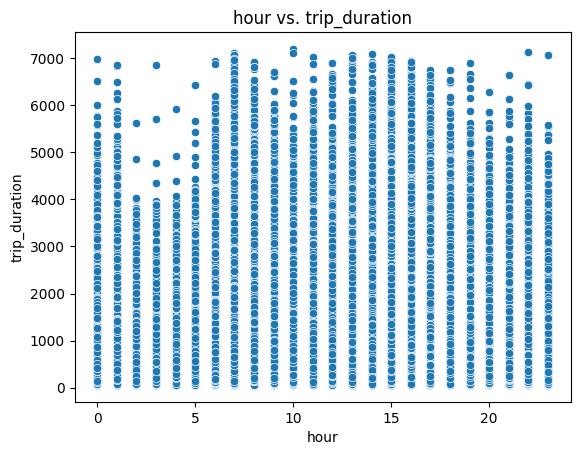

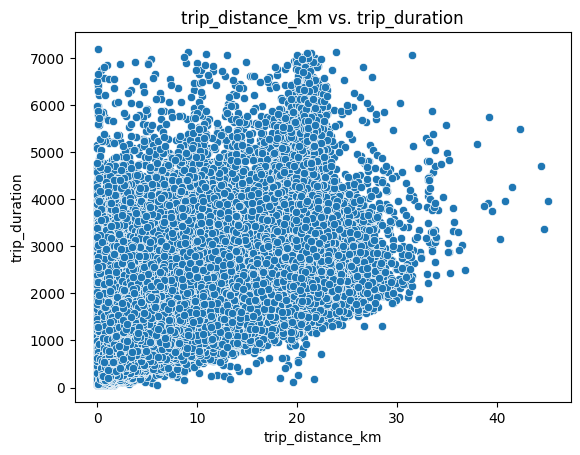

In [31]:
# Use Scatter plot to visualize relationship between numeric features and target
numeric_features = [col for col in numeric_cols.tolist() if col != "trip_duration"]

for feature in numeric_features:
    sns.scatterplot(data=train_data_clean, x=feature, y="trip_duration")
    plt.title(f"{feature} vs. trip_duration")
    plt.show()

In [32]:
# Compute correlation coefficient between each numeric feature with the target variable
print("Correlation between target and:")
for feature in numeric_features:
    corr = train_data_clean[feature].corr(train_data_clean["trip_duration"])
    print(f"- {feature}: {corr}")

Correlation between target and:
- passenger_count: 0.018195892747330647
- pickup_longitude: 0.36862432015746405
- pickup_latitude: -0.23963452364335272
- dropoff_longitude: 0.22953512707016074
- dropoff_latitude: -0.19282357365812497
- month: 0.06024635968737587
- day_of_week: -0.033831131054344626
- hour: 0.02876555754475127
- trip_distance_km: 0.7715236297075946


**Insights**

- Only `trip_distance_km` had a strong correlation with the target variable, but this would be expected considering longer distance trips tend to take longer.
- There is slight correlation between the pickup and dropoff coordinates with the prediction target, indicating that the pick up and drop off points have some predictive power due to their geographical aspects.
- The rest of the features (temporal data and passenger count) show weak correlation with the target, which may indicate the non-linearity of the data and possibility of using non-linear models to better predict `trip_duration`.

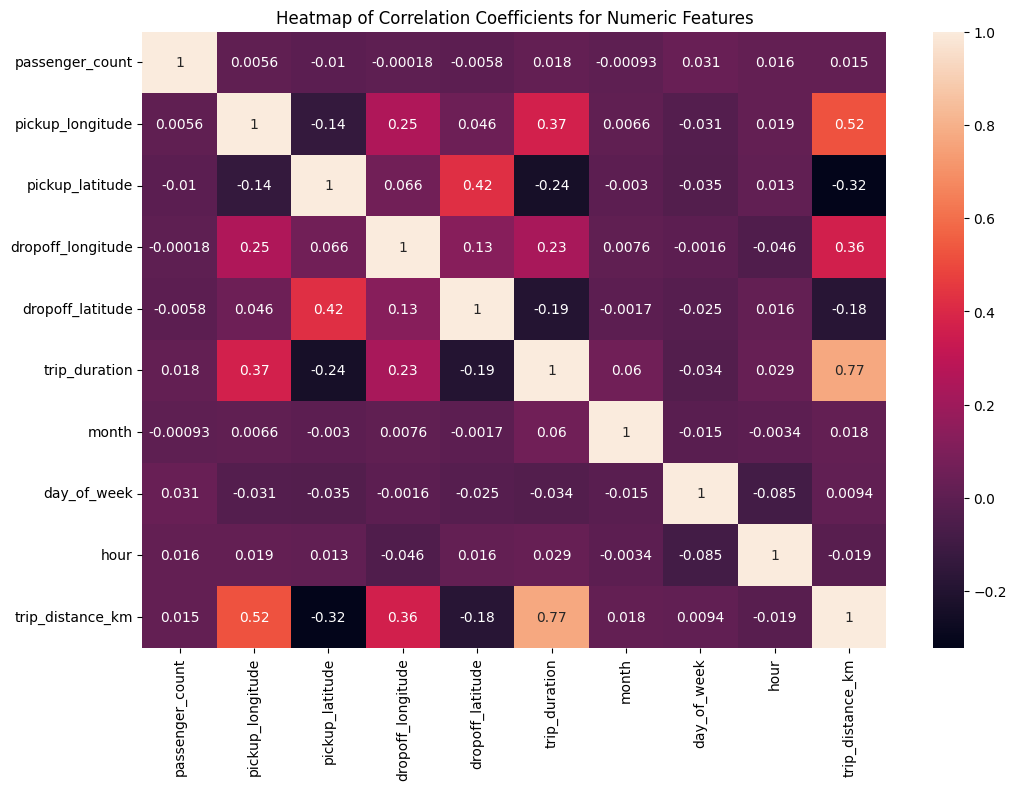

In [33]:
# Compute correlation coefficient between all numeric column pair to check for multicollinearity
correlations = train_data_clean[numeric_cols].corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, annot=True)

plt.title("Heatmap of Correlation Coefficients for Numeric Features")
plt.show()

**Insights**

- The features with moderate correlation with each other are as expected, which validates that the dataset now only contains valid records. These include:
  - `trip_distance_km` and `trip_duration` 
  - Pickup and Dropoff coordinates
  - Coordinates with `trip_distance_km`
- The rest of features show low correlation with each other, which indicates that the data has little to no multicollinearity. This means each feature may have its own unique predictive power. 
- Additionally, these features have low correlations with the prediction target, which further supports that these features alone are not sufficient for predicting `trip_duration`, which emphasizes the importance of capturing patterns about the interactions between them for model training. 

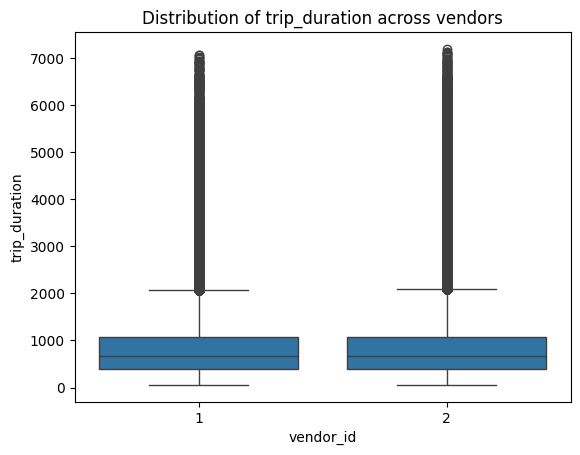

In [34]:
# Use box plots to visualize the relationship between categorical variable (vendor_id) and trip_duration
sns.boxplot(data=train_data_clean, x="vendor_id", y="trip_duration")

plt.title("Distribution of trip_duration across vendors")
plt.show()

**Insights**

- Based on the visualization, the distribution of trip_duration is very similar across the two taxi vendors with the most concentration of trips within 1000 seconds (~17mins).
- This indicates that the `vendor_id` appears to have little predictive power on its own. However, this feature will be kept to first see if the model can capture interactions between this feature and the others. 

# Data Preprocessing

In [35]:
# Since there is only one categorical variable, the OH encoding is specific to this feature
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

vendor_encoded = pd.DataFrame(
    encoder.fit_transform(train_data_clean[["vendor_id"]]),
    columns=encoder.get_feature_names_out(["vendor_id"]),
    index=train_data_clean.index
)

# Add encoded features and drop the original categorical features
X = pd.concat([train_data_clean.drop(columns=["trip_duration", "vendor_id"]), vendor_encoded], axis=1)

# Extract prediction target
y = train_data_clean["trip_duration"].copy()

print(X.shape)
print(y.shape)

(1398726, 13)
(1398726,)


In [36]:
X.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day_of_week,hour,is_weekend,is_rush_hour,trip_distance_km,vendor_id_1,vendor_id_2
0,1,-73.982155,40.767937,-73.964630,40.765602,3,0,17,False,True,1.498523,0.0,1.0
1,1,-73.980415,40.738564,-73.999481,40.731152,6,6,0,True,False,1.805510,1.0,0.0
2,1,-73.979027,40.763939,-74.005333,40.710087,1,1,11,False,False,6.385107,0.0,1.0
3,1,-74.010040,40.719971,-74.012268,40.706718,4,2,19,False,True,1.485500,0.0,1.0
4,1,-73.973053,40.793209,-73.972923,40.782520,3,5,13,True,False,1.188590,0.0,1.0


In [37]:
# Log transform target variable
y_log = np.log1p(y)
y_log.head()

0    6.122493
1    6.498282
2    7.661527
3    6.063785
4    6.077642
Name: trip_duration, dtype: float64

# Modeling


## Model Selection

The following regression models are selected for comparison:
- Linear Regression (Depends on linear features, so this might struggle considering the findings in EDA)
- Random Forest (Trains multiple decision trees on different samples of the data, which is useful for overcoming overfitting)
- XGBoost (Iteratively improves itself, considered as the standard in terms of models for structured data)

In [38]:
# Initializing the models
models = {
    "linear_regression": LinearRegression(),
    "random_forest": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "xgboost": XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
}

## Evaluation Metric

The Kaggle competition uses [Root Mean Squared Logarithmic Error (RMSLE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_log_error.html) to evaluate the performance of models. Thus, this will also be used in this project. Specifically, this metric is useful for this dataset since the prediction target is heavily skewed and RMSLE is designed to handle this. It is also worth noting that RMSLE penalizes underestimation more than overestimation.

In [39]:
def rmsle(y_true, y_pred):
    # This ensures predictions are non-negative since RMSLE needs non-negative predictions
    return np.sqrt(root_mean_squared_log_error(y_true, np.maximum(y_pred, 0))) 

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## Training and Evaluation

In [40]:
# Split into 5 folds which is considered as the standard
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():

    # Evaluate the current model using cross-validation
    scores = cross_val_score(model, X, y_log, cv=kf, scoring=rmsle_scorer)

    mean_score = -scores.mean() # So that the error is displayed as positive
    std_score = scores.std() # To check if the results from each split are far off or close to each other

    print(f"{name} RMSLE (Mean): {mean_score:.4f}; Std Dev: {std_score:.4f}")

linear_regression RMSLE (Mean): 0.2699; Std Dev: 0.0002
random_forest RMSLE (Mean): 0.2138; Std Dev: 0.0003
xgboost RMSLE (Mean): 0.2164; Std Dev: 0.0003


## Previous Experiments

- **Trial 0**
  - Used original features before feature engineering
  - Used default parameters for each model
  - Results:
    - Linear Regression: 0.0935
    - ***Random Forest: 0.0521***
    - XGBoost: 0.0556
- **Trial 1**
  - Added derived features
  - Still used the default parameters for each model
  - Results:
    - Linear Regression: 0.0727
    - ***Random Forest: 0.0457***
    - XGBoost: 0.0469
- **Trial 2**
  - Added cross-validation
  - Default parameters for each model
  - Results (Latest):
    - Linear Regression RMSLE (mean): 0.2699, Std: 0.0002
    - ***Random Forest RMSLE (mean): 0.2138, Std: 0.0003***
    - XGBoost RMSLE (mean): 0.2164, Std: 0.0003
- **Trial 3**
  - Added hyperparameter tuning, however did not complete due to time and computing constraints

## Saving Best Model

In [42]:
joblib.dump(models["random_forest"], "models/rf_best_model.joblib")

['models/rf_best_model.joblib']

# Conclusions and Recommendations

## Conclusions
- The dataset required extensive data cleaning, particularly feature engineering was a critical step in creating more insightful features that had better predictive power than the initial features of the dataset. The creation of these new derived features improved the performance of the model significantly during experiments.
- Cross-validation was a pivotal step in the right direction, as initial experiments yielded unusually low errors from the start. After utilizing cross-validation, the model's performance dipped but the results were far more realistic. This would enable the model to be evaluated in a more robust way, thereby also improving its generalizability especially to unseen data.
- Of the three models, Linear Regression consistently lagged behind both Random Forest and XGBoost. This is supported by the findings during EDA wherein most features had low (linear) correlation coefficients with the target variable, which were the probable cause to Linear Regression's struggles. 
- Random Forest and XGBoost had very similar results, with RF having the slight advantage in RMSLE scores (RF - 0.2138; XGB - 0.2164). However, in terms of training XGBoost was significantly faster than RF which showed a performance to speed tradeoff between the two.
- The best model was selected to be RF due to its slight advantage in RMSLE with additional factors such as being more interpretable and robust to overfitting compared to XGBoost. 

## Recommendations
- Explore other ML algorithms or even neural networks to hopefully further minimize error.
- Refine feature engineering by creating richer features with better predictive power, or by integrating external data sources to improve feature quality and depth.
- Conduct feature importance analysis to determine which features have the highest predictive power for the target. 
- Add the completed hyperparameter tuning, which was not included due to time constraints and slow tuning progress due to it beign computationally intensive. 